# 2. EIA를 이용한 Torchscript Inference
---

본 모듈에서는 Amzaon SageMaker API에서 Amazon Elastic Inference Accelerator는를 이용하여 CPU에서 cost-optimized하게 inference 를 수행해 봅니다.
<p><img src="./imgs/eia.png" width="500", height="50"></p>
Amazon Elastic Inference Accelerator는 GPU 기반 추론 가속화의 올바른 양을 Amazon EC2, Amazon SageMaker 인스턴스 유형 또는 Amazon ECS 작업에 연결할 수 있습니다. 따라서 이제 애플리케이션의 전체 컴퓨팅, 메모리 및 스토리지 요구 사항에 가장 적합한 인스턴스 유형을 선택한 후 필요한 양의 추론 가속을 별도로 구성할 수 있습니다.
저렴한 비용으로 딥 러닝 학습 추론 작업량을 가속화하기 위해 모든 EC2 인스턴스, SageMaker 인스턴스 또는 ECS 작업과 함께 작동하도록 설계된 GPU 기반 하드웨어 장치입니다. Amazon Elastic Inference를 사용하여 EC2 인스턴스 또는 ECS 작업을 시작하면 액셀러레이터가 네트워크를 통해 인스턴스에 프로비저닝되고 연결됩니다. Amazon Elastic Inference에 사용할 수 있는 TensorFlow Serving, Apache MXNet 및 PyTorch와 같은 딥 러닝 도구 및 프레임워크는 연결된 엑셀러레이터에 모델 계산을 자동으로 감지하고 오프로드할 수 있습니다.

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install --upgrade pip --trusted-host pypi.org --trusted-host files.pythonhosted.org
!{sys.executable} -m pip install https://download.pytorch.org/whl/cpu/torchvision-0.4.2%2Bcpu-cp36-cp36m-linux_x86_64.whl --use-feature=2020-resolver
!{sys.executable} -m pip install https://s3.amazonaws.com/amazonei-pytorch/torch_eia-1.3.1-cp36-cp36m-manylinux1_x86_64.whl --use-feature=2020-resolver

!{sys.executable} -m pip install graphviz==0.13.2   
!{sys.executable} -m pip install mxnet-model-server==1.0.8
!{sys.executable} -m pip install pillow==7.1.0
!{sys.executable} -m pip install sagemaker_containers
!{sys.executable} -m pip install -U sagemaker

     |████████████████████████████████| 1.5 MB 20.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 13.5 MB 26.4 MB/s eta 0:00:01
     |████████████████████████████████| 734.6 MB 11 kB/s s eta 0:00:016  |█▏                              | 26.1 MB 5.8 MB/s eta 0:02:03     |██                              | 46.1 MB 5.8 MB/s eta 0:02:00     |██                              | 47.5 MB 19.1 MB/s eta 0:00:36     |███▎                            | 74.9 MB 19.1 MB/s eta 0:00:35     |███▌                            | 80.2 MB 19.1 MB/s eta 0:00:35     |████▏                           | 96.9 MB 19.1 MB/s eta 0:00:34     |███████                         | 159.8 MB 106.5 MB/s eta 0:00:06     |███████▋                        | 175.2 MB 52.2 MB/s eta 0:00:11     |████████                        | 184.3 MB 52.2 MB/s eta 0:00:11     |████████████▋        

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.restart();

<IPython.core.display.Javascript object>

In [1]:
from PIL import Image
from sagemaker import get_execution_role
from sagemaker import predictor

import src_dir.util as util

import os
import boto3
import time
import subprocess
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import distributed as dist
from PIL import Image
from torchvision import transforms, models
import sagemaker

In [2]:
%store -r

In [3]:
role = get_execution_role()

## 1.Trace_model 생성
Pytorch의 경우 Elastic Inference에서 사용하기 위해서는 [TorchScript](https://pytorch.org/docs/1.3.1/jit.html)로 모델을 compile 해야 합니다. TorchScript로 compile하는 방법은 tracing과 scripting 2가지 방법을 사용하여 compile이 가능하며, 두 경우 모두 computation graph를 생성하게 됩니다. 

scripting 방식은 Torchscript를 compile하는데 선호하는 방식 중 하나이며, 모든 모델의 로직이 유지됩니다. 하지만, scripted할 수 있는 모델들이 tracing 방식보다 작기 때문에 이 점을 고려해서 이 모듈에서는 tracing 방식을 사용할 예정입니다. 모델에 따라서는 두 방식 모두 TorchScript에 compatible하지 않을 수 있으며 그럴 경우 모델의 수정이 필요할 수 있습니다.

EIA는 현재 Pytorch 1.3.1에서 지원이 가능하며, control-flow operations를 다루기 때문에 많이 conditional branch가 포함된 모델을 scripting 방식으로 수행하게 되면 inference의 latency가 발생할 수 있습니다. 또한, Pytorch 1.3.1에서는 scripting 방식보다는 tracing 방식이 더 좋다는 의견이 있습니다.

In [4]:
model = util.torch_model(hyperparameters['model_name'])

=> using pre-trained model 'resnet50'


In [5]:
%store -r model_dir

In [6]:
multigpus_distributed = True

In [7]:
## multigpus_distributed
if multigpus_distributed:
    model = torch.nn.DataParallel(model)
with open(os.path.join(model_dir, 'model_best.pth'), 'rb') as f:
    model_load = torch.load(f, map_location=torch.device('cpu'))
    class_to_idx = model_load['class_to_idx']
    state_dict = model_load['state_dict']
    model.load_state_dict(state_dict)

In [8]:
model_out_dir ='./model_result'
!rm -rf $model_out_dir
!mkdir $model_out_dir

Tracing 방식은 특정 input을 모델에 실행했을 때 수행되면서 operation이 저장하기 때문에, random으로된 input을 수행하여 operation을 record합니다.

In [9]:
save_dir = os.path.join(model_out_dir, "model.pt")
cv_input = torch.rand(1,3,hyperparameters['width'],hyperparameters['height'])
model = torch.jit.trace(model.eval(), cv_input)
torch.jit.save(model, save_dir)

In [10]:
traced_model = torch.jit.load(os.path.join(model_out_dir, 'model.pt'))

## 2.Test_Traced_model


In [11]:
def get_image(filename):
    im = Image.open(filename)

    transform = transforms.Compose([
        transforms.Resize((hyperparameters['width'],hyperparameters['height'])),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    img_data = transform(im)
    return img_data.unsqueeze(0)

In [12]:
filename='./dataset/val/Abyssinian/Abyssinian_102.jpg'

In [13]:
im = get_image(filename)

torch.jit.optimized_execution블록은 Elatic Inference에서 traced model을 사용하기 위해 필요합니다.

In [14]:
with torch.jit.optimized_execution(True, {'target_device': 'eia:0'}):
  # You can trace with any input
    output = traced_model(im)
print(output.max(1, keepdim=True)[1].numpy()[0][0])

0


## 3. writing Inference.py

In [15]:
%%writefile ./src_dir/inference.py

from __future__ import absolute_import

import argparse
import json
import logging
import os
import sys
import time
import random
from os.path import join
import numpy as np
import io
import tarfile

import boto3
import sagemaker_containers as smc

from PIL import Image

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
import copy
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms, models

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

JSON_CONTENT_TYPE = 'application/json'


def model_fn(model_dir):
    """
    This function is called by the Pytorch container during hosting when running on SageMaker with
    values populated by the hosting environment.

    This function loads models written during training into `model_dir`.
    """
    
    print("****model_dir : {}".format(model_dir))
    traced_model = torch.jit.load(os.path.join(model_dir, 'model_result/model.pt'))
    return traced_model


def input_fn(request_body, request_content_type='application/x-image'):
    """This function is called on the byte stream sent by the client, and is used to deserialize the
    bytes into a Python object suitable for inference by predict_fn .
    """
    logger.info('An input_fn that loads a image tensor')
    if request_content_type == 'application/x-image':
        img = Image.open(io.BytesIO(request_body))
#         img_arr = np.array(Image.open(io.BytesIO(request_body)))
#         img = Image.fromarray(img_arr.astype('uint8')).convert('RGB')

        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        img_data = transform(img)
        return img_data
    else:
        raise ValueError(
            'Requested unsupported ContentType in content_type : ' + request_content_type)


def predict_fn(input_data, model):
    """
    This function receives a NumPy array and makes a prediction on it using the model returned
    by `model_fn`.
    """
    logger.info('Entering the predict_fn function')
    input_data = input_data.unsqueeze(0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    result = {}
    with torch.no_grad():
        with torch.jit.optimized_execution(True, {"target_device": "eia:0"}):
            output = model(input_data)
            pred = output.max(1, keepdim=True)[1]
            result['output'] = output.numpy()
            result['pred'] = pred
    return result        


def output_fn(prediction_output, accept=JSON_CONTENT_TYPE):
    """This function is called on the return value of predict_fn, and is used to serialize the
    predictions back to the client.
    """
    return json.dumps({'result': prediction_output['output'].tolist(), 'pred': prediction_output['pred'].tolist()}), accept

Overwriting ./src_dir/inference.py


## 3. JIT 이용한 Model_deploy

In [16]:
tar_filename = 'test_model.tar.gz'

In [17]:
subprocess.call(['tar', '-czvf', tar_filename, os.path.join(model_out_dir, 'model.pt')])

0

In [18]:
!aws s3 cp $tar_filename $artifacts_dir

upload: ./test_model.tar.gz to s3://sagemaker-us-east-1-322537213286/training-job-1596634651/output/test_model.tar.gz


In [19]:
sm = boto3.Session().client(service_name='sagemaker')
list_endpoints = sm.list_endpoints()

for ep in list_endpoints['Endpoints']:
    sm.delete_endpoint(EndpointName=ep['EndpointName'])
    

NextToken = 'None'
while NextToken !='':
    lec = sm.list_endpoint_configs(NextToken=NextToken) if NextToken != 'None' else sm.list_endpoint_configs()
    for epc in lec['EndpointConfigs']:
        print(epc['EndpointConfigName'])
        sm.delete_endpoint_config(EndpointConfigName=epc['EndpointConfigName'])
        time.sleep(3)
    NextToken = lec['NextToken'] if lec.get('NextToken') else ''

NextToken = 'None'
while NextToken !='':
    lec = sm.list_models(NextToken=NextToken) if NextToken != 'None' else sm.list_models()
    for epc in lec['Models']:
        print(epc['ModelName'])
        sm.delete_model(ModelName=epc['ModelName'])
        time.sleep(3)
    NextToken = lec['NextToken'] if lec.get('NextToken') else ''

endpoint-pet-classifier-1596630746
pytorch-inference-eia-2020-08-05-12-32-51-307


In [20]:
from sagemaker.pytorch.model import PyTorchModel

In [21]:
endpoint_name = "endpoint-pet-classifier-{}".format(int(time.time()))


pytorch_model = PyTorchModel(model_data=artifacts_dir + 'test_model.tar.gz', 
                                   role=role,
                                   entry_point='./src_dir/inference.py',
                                   framework_version='1.3.1', 
                                   py_version='py3',
                                   container_log_level='error')

pytorch_model.deploy(instance_type='ml.c5.large', 
                     initial_instance_count=1, 
                     accelerator_type='ml.eia2.large', 
                     endpoint_name=endpoint_name,
                     wait=False)

## 4. Model 결과 확인 (Locally)

여러분의 개인 랩탑/데스크탑이나 온프레미스에서 수행하는 방법과 동일하게 배치 데이터도 쉽게 추론이 가능합니다.  
본 예시에서는 테스트 데이터에 대해서 간단하게 배치 추론을 수행해 보고, 기본적인 평가 지표들인 ```Confusion Matrix```, ```AUROC(Area Under a ROC Curve)```, ```AUPRC(Area Under a Precision-Recall Curve)```를 확인해 보겠습니다.

In [36]:
import glob
import numpy as np
from util import inference_utils as iu

In [37]:
idx_to_class = {}
for class_name in class_to_idx:
    idx_to_class[class_to_idx[class_name]] = class_name

In [38]:
test_img_path = './dataset/test/*/*'
test_img_list = glob.glob(test_img_path)

In [39]:
y_true_str = [img_list.split('/')[3] for img_list in test_img_list]
y_true = np.array([class_to_idx[s] for s in y_true_str])

In [40]:
y_pred = []
y_score = []
y_pred1 = []
y_score1 = []
y_revised_true = []
with torch.jit.optimized_execution(True, {'target_device': 'eia:0'}):
    for i, test_img in enumerate(test_img_list):
        try:
            im = get_image(test_img)
            output = traced_model(im)
            output = output[:, 0:37]
            softmax = np.exp(output)/np.exp(output).sum()
            result = softmax.max(1, keepdim=True)
            indices = result[1].numpy()[0][0]
            y_score.extend(softmax.numpy())
            y_pred.append(indices)
            y_revised_true.append(y_true[i])
        except:
            pass

In [41]:
y_score = np.array(y_score)
y_pred = np.array(y_pred)
y_revised_true = np.array(y_revised_true)

In [42]:
y_score.shape

(739, 37)

다중 클래스의 plotting에 필요한 컬러 테이블을 랜덤하게 생성합니다.

In [43]:
import random
color_table = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(class_to_idx))]

In [44]:
labels=list(class_to_idx.keys())

                            precision    recall  f1-score   support

                Abyssinian       0.83      0.26      0.40        19
                    Bengal       1.00      0.40      0.57        20
                    Birman       0.92      0.55      0.69        20
                    Bombay       0.80      0.80      0.80        20
         British_Shorthair       0.52      0.70      0.60        20
              Egyptian_Mau       0.83      0.75      0.79        20
                Maine_Coon       0.90      0.45      0.60        20
                   Persian       0.41      0.80      0.54        20
                   Ragdoll       0.67      0.30      0.41        20
              Russian_Blue       0.71      0.75      0.73        20
                   Siamese       0.93      0.65      0.76        20
                    Sphynx       0.45      0.85      0.59        20
          american_bulldog       0.50      0.35      0.41        20
 american_pit_bull_terrier       0.42      0.25

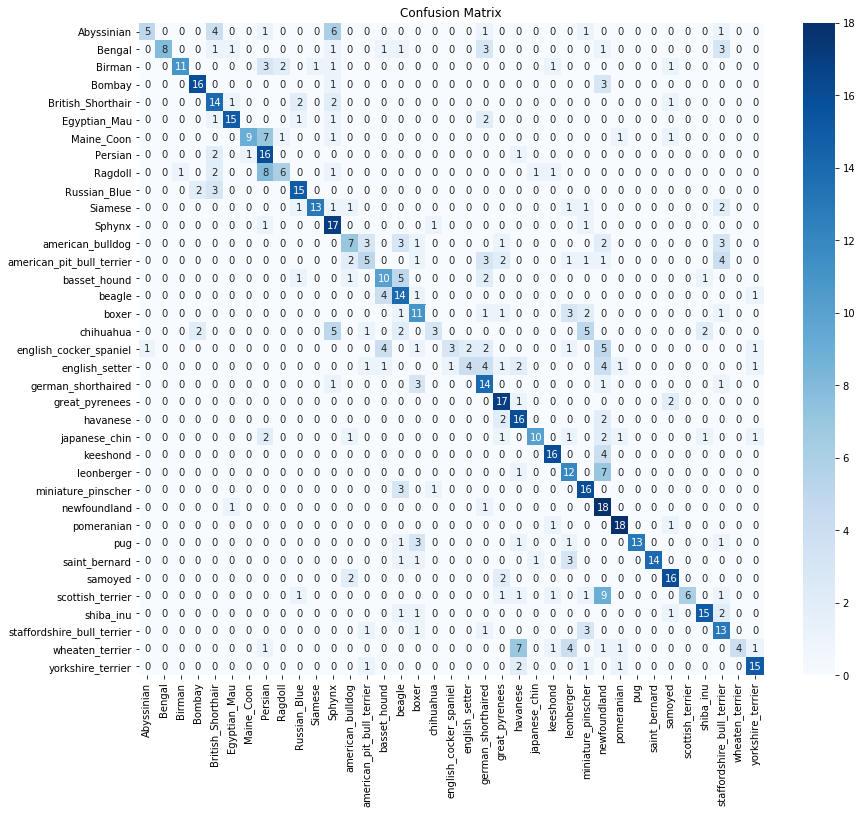

In [45]:
iu.plot_conf_mtx_multiclass(y_revised_true, y_pred, labels)

In [46]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto', sparse=False)
num_classes = len(labels)

y_true_ohe = enc.fit_transform(y_revised_true.reshape(-1, 1))
y_pred_ohe = enc.fit_transform(y_pred.reshape(-1,1))

y_pred_str = [idx_to_class[int(score)] for score in y_pred]

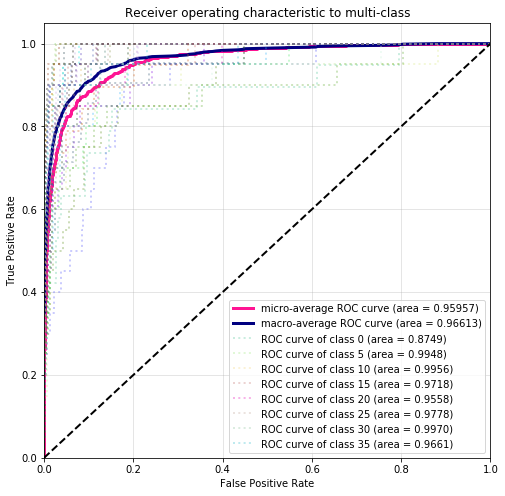

In [47]:
iu.plot_roc_curve_multiclass(y_true_ohe, y_score, num_classes, color_table)

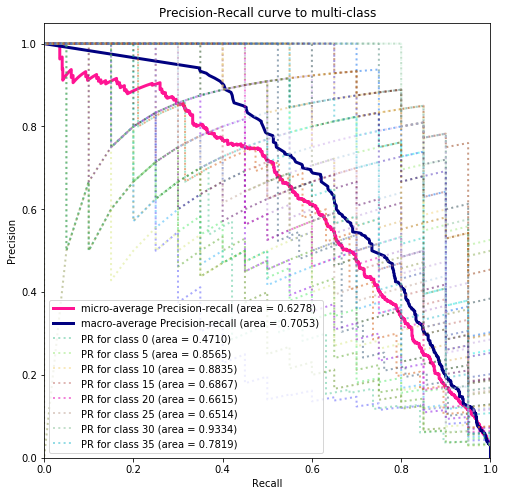

In [48]:
iu.plot_pr_curve_multiclass(y_true_ohe, y_score, num_classes, color_table)

## 5. Model 결과 확인 (SageMaker Endpoint)

In [49]:
client = boto3.client('sagemaker')
waiter = client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

In [50]:
with open(filename, mode='rb') as file:
    img = file.read()

In [51]:
predictor.Predictor.accept = 'application/json'
predictor.Predictor.content_type = 'application/x-image'

t_pred = []
t_gt = []

response = predictor.Predictor(endpoint_name=endpoint_name)

In [52]:
import json

In [53]:
response.predict(img)

b'{"result": [[11.175384521484375, 7.792922496795654, 6.6564788818359375, 11.218087196350098, 14.139801025390625, 7.7347941398620605, 6.201871395111084, 7.35292911529541, 7.989270210266113, 18.78957748413086, 9.670409202575684, 12.59289836883545, 6.9308342933654785, 7.721391677856445, 6.387752532958984, 6.172917366027832, 6.308414936065674, 9.672162055969238, 6.535468101501465, 5.812471389770508, 7.853182792663574, 6.590991973876953, 7.772897243499756, 6.267091274261475, 7.264768123626709, 5.973944187164307, 9.227934837341309, 6.923498630523682, 6.4632182121276855, 8.512094497680664, 3.4205880165100098, 5.94531774520874, 6.2912116050720215, 7.181699275970459, 8.448554039001465, 5.161148548126221, 4.632535934448242, -19.280441284179688, -13.354104042053223, -14.341143608093262, -13.307761192321777, -15.34174633026123, -15.155743598937988, -13.869912147521973, -13.600584983825684, -15.77416706085205, -15.168594360351562, -10.556790351867676, -12.659380912780762, -16.222064971923828, -14.

In [54]:
%timeit response.predict(img)

56.1 ms ± 7.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
